In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [8]:
ticker = 'AAPL'
start_date = '2020-01-01'
end_date = '2021-01-01'
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [12]:
def calculate_parabolic_sar(df, af_step=0.02, af_max=0.2):
    high = df['High'].values
    low = df['Low'].values
    close = df['Close'].values

    n = len(df)
    sar = np.zeros(n)
    ep = np.zeros(n)
    af = np.full(n, af_step)
    trend = np.full(n, True)

    sar[0] = low[0]
    ep[0] = high[0]
    
    for i in range(1, n):
        if trend[i-1]:
            sar[i] = sar[i-1] + af[i-1] * (ep[i-1] - sar[i-1])
            sar[i] = min(sar[i], low[i], low[i-1])
            if high[i] > ep[i-1]:
                ep[i] = high[i]
                af[i] = min(af[i-1] + af_step, af_max)
            else:
                ep[i] = ep[i-1]
                af[i] = af[i-1]
            if low[i] < sar[i]:
                trend[i] = False
                sar[i] = ep[i-1]
                ep[i] = low[i]
                af[i] = af_step
        else:
            sar[i] = sar[i-1] + af[i-1] * (ep[i-1] - sar[i-1])
            sar[i] = max(sar[i], high[i], high[i-1])
            if low[i] < ep[i-1]:
                ep[i] = low[i]
                af[i] = min(af[i-1] + af_step, af_max)
            else:
                ep[i] = ep[i-1]
                af[i] = af[i-1]
            if high[i] > sar[i]:
                trend[i] = True
                sar[i] = ep[i-1]
                ep[i] = high[i]
                af[i] = af_step

    df['Parabolic SAR'] = sar
    return df

In [13]:
data = calculate_parabolic_sar(data)

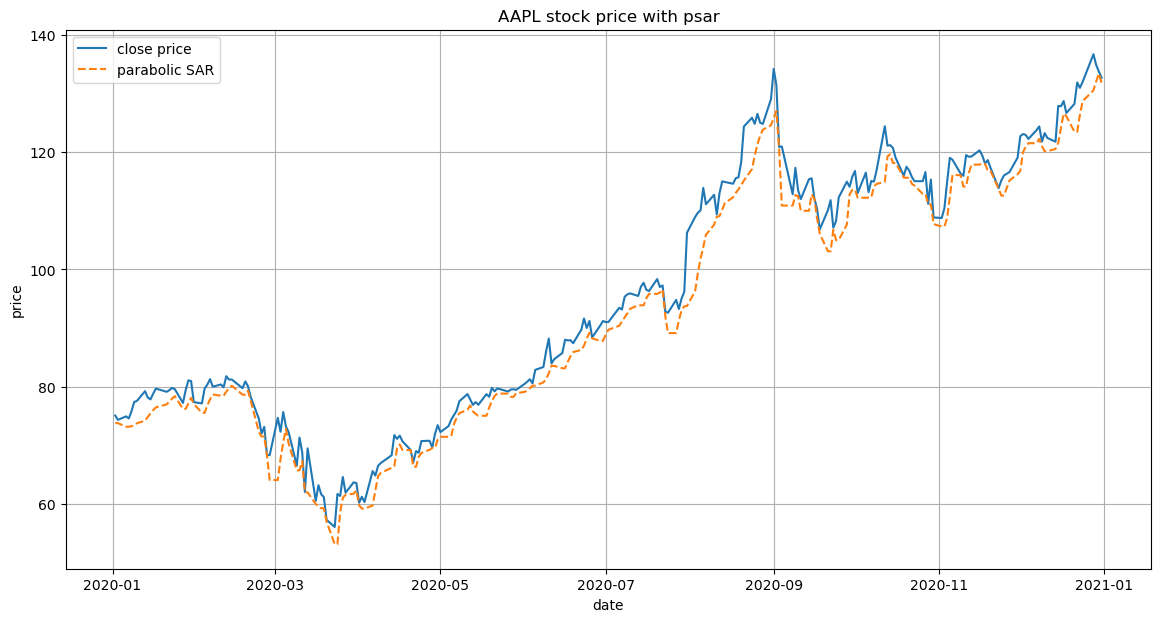

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='close price')
plt.plot(data.index, data['Parabolic SAR'], label='parabolic SAR', linestyle='--')
plt.title(f'{ticker} stock price with psar')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.show()